In [12]:
from torch import optim, nn
from torchvision import models 
from torchvision import transforms as T 
from torchvision.datasets import ImageFolder
from sklearn.model_selection import train_test_split
from torch.utils.tensorboard import SummaryWriter
import torch
# from torch.cuda.amp import autocast, GradScaler
import numpy as np 
import matplotlib.pyplot as plt
from torch.utils.data import Subset, DataLoader, SubsetRandomSampler
import pandas as pd 

In [13]:
device = torch.device('cuda' if torch.cuda.is_available else 'cpu')

In [14]:
torch.cuda.empty_cache()
torch.backends.cudnn.benchmark = True

In [15]:
data_transforms = T.Compose([
        T.Resize((224, 224)),
        T.ToTensor(),
        T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])
dataset = ImageFolder(root='images', transform=data_transforms)

In [16]:
# convert labels to integers
dataset.classes = [int(i) for i in dataset.classes]

In [17]:
for (_, (img, _)) in enumerate(dataset):
    img = img.unsqueeze(0)

In [18]:
dataset_size = len(dataset)
dataset_indices = list(range(dataset_size))
np.random.shuffle(dataset_indices)

In [19]:
test_split_indices = int(np.floor(0.2 * dataset_size))
train_indices, test_indices = dataset_indices[test_split_indices:], dataset_indices[:test_split_indices]

In [20]:
train_sampler = SubsetRandomSampler(train_indices)
test_sampler = SubsetRandomSampler(test_indices)

In [21]:
train_loader = DataLoader(dataset=dataset, shuffle=False, batch_size=32, sampler=train_sampler,num_workers=8)
test_loader = DataLoader(dataset=dataset, shuffle=False, batch_size=32, sampler=test_sampler, num_workers=8)

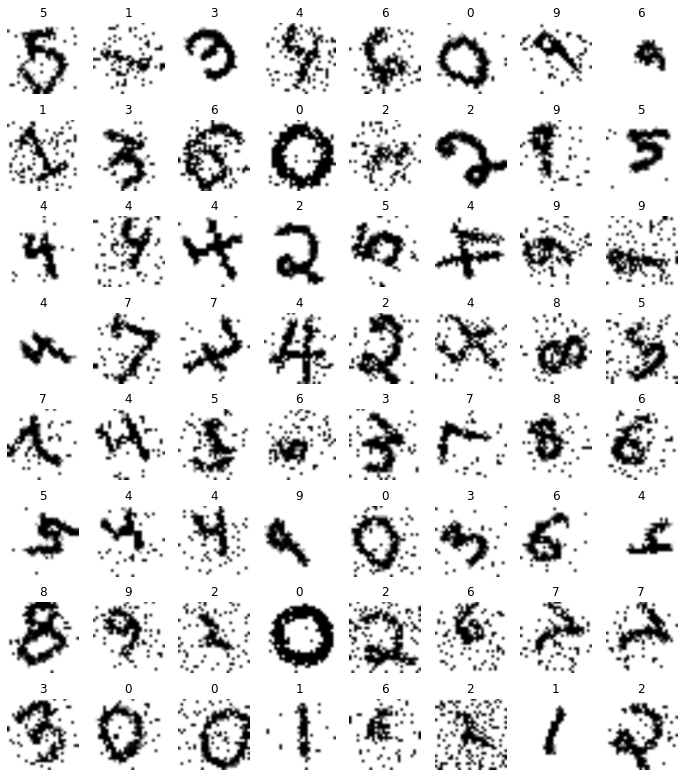

In [22]:
figure = plt.figure(figsize=(12, 12), linewidth=10)
cols, rows = 8, 8

for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_loader.dataset), size=(1,)).item()
    img, label = train_loader.dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis('off')
    img = img.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    plt.imshow(img, cmap='gray')

plt.subplots_adjust(top=1.)    
plt.show()

In [23]:
# create network
net = models.vgg16_bn(pretrained=True)
net.classifier[6] = nn.Sequential(nn.Linear(4096, 1000),
                                        nn.ReLU(inplace=True),
                                        nn.Dropout(0.5),
                                        nn.Linear(1000, 10))
net = net.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)
writer = SummaryWriter()

In [24]:
EPOCHS = 1

In [25]:
torch.cuda.empty_cache()

In [27]:
for epoch in range(EPOCHS):
    
    total_loss = 0.0
    total_correct = 0
    
    # set network to training mode
    net.train()
    
    for i, data in enumerate(train_loader):
        
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        
        # clear the gradients 
        optimizer.zero_grad()
        
        # forward pass
        outputs = net(images)
        
        # compute loss
        loss = criterion(outputs, labels)
        
        # backpropagation step
        loss.backward()
       
        # update parameters
        optimizer.step()
        
        total_loss += loss.detach().item()
        total_correct += outputs.argmax(dim=1).eq(labels).sum().item()
        
    # run validation loop every 10 epochs
    if epoch % 10 == epoch - 1:
        
        # set network to evaluation mode
        net.eval()
        
        with torch.no_grad():
            
            correct = 0
            total = 0
            total_loss = 0.0
            
            for i, data in test_loader:
                        
                images, labels = data
                images, labels = images.to(device), labels.to(device)
                
                # clear the gradients
                optimizer.zero_grad()
                
                # forward pass
                outputs = net(images)
                
                # calculate loss
                loss = criterion(outputs, labels)
                
                # obtain predictions
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                
                # verify predictions
                correct += (predicted == labels).sum().item()
                accuracy = correct / total 
            
            writer.add_scalar("Test Loss", total_loss, epoch)
            writer.add_scalar("Test Accuracy", 100 * (correct / total))
            
    writer.add_scalar("Train Loss", total_loss, epoch)
    writer.add_scalar("Train Accuracy", 100 * (total_correct / len(train_loader)), epoch)

RuntimeError: CUDA error: CUBLAS_STATUS_NOT_INITIALIZED when calling `cublasCreate(handle)`